In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pickle
from tqdm import trange
%matplotlib inline

First we will read in the data that I processed on GCP

For simplicity, I will start with the L-band files from turboSETI, and then make a function so that I can repeat the process on other bands as well as the energy detection data

In [2]:
dir_path = "/home/danielb/fall_2021/spectral_occupancy/"
ts = dir_path + "turbo-seti/"
ed = dir_path + "energy-detection/"
fine = ed + "fine_channel_fraction/"

In [3]:
ts_pickles = glob.glob(ts+"*pkl")
ed_pickles = glob.glob(ed+"*pkl")

In [4]:
def read_pickle(pickle_path):
    with open(pickle_path, "rb") as f:
        contents = pickle.load(f)
    return contents

In [5]:
l_band = read_pickle(ts_pickles[2])

In [6]:
def sample_spectrum(spectral_occupancy):
    return np.random.random(size=len(spectral_occupancy))

def simulate_cadence(spectral_occupancy):
    on_target = np.empty(shape=(3, len(spectral_occupancy)), dtype=bool)
    off_target= np.empty(shape=(3, len(spectral_occupancy)), dtype=bool)
    for i in range(3):
        on_target[i,:] = sample_spectrum(spectral_occupancy) <= spectral_occupancy
    
    for i in range(3):
        off_target[i, :] = sample_spectrum(spectral_occupancy) <= spectral_occupancy
    
    return on_target, off_target

def signal_search(spectral_occupancy):
    """
    currently set to filter level 3:
    events that are present in *ALL* ons
    and found in *NO* offs 
    """
    on, off = simulate_cadence(spectral_occupancy)
    # signals should be present in all ons
    all_on = np.sum(on, axis=0) == 3
    
    # signals should be absent in all offs
    no_off = np.sum(off, axis=0) == 0
    
    #check that hits are present in "ons" and absent in "offs"
    hit_detection = (all_on & no_off)
    
    return hit_detection

def search_n_times(spectral_occupancy, N_iterations=10000):
    search_results = np.empty(shape=(N_iterations, len(spectral_occupancy)))
    
    for i in trange(N_iterations):
        search_results[i,:] = signal_search(spectral_occupancy)
    
    return search_results

In [7]:
results = search_n_times(l_band["bin_heights"])
event_counts = np.sum(results, axis=0)

100%|██████████| 10000/10000 [00:00<00:00, 11241.90it/s]


100%|██████████| 10000/10000 [00:02<00:00, 3511.60it/s]


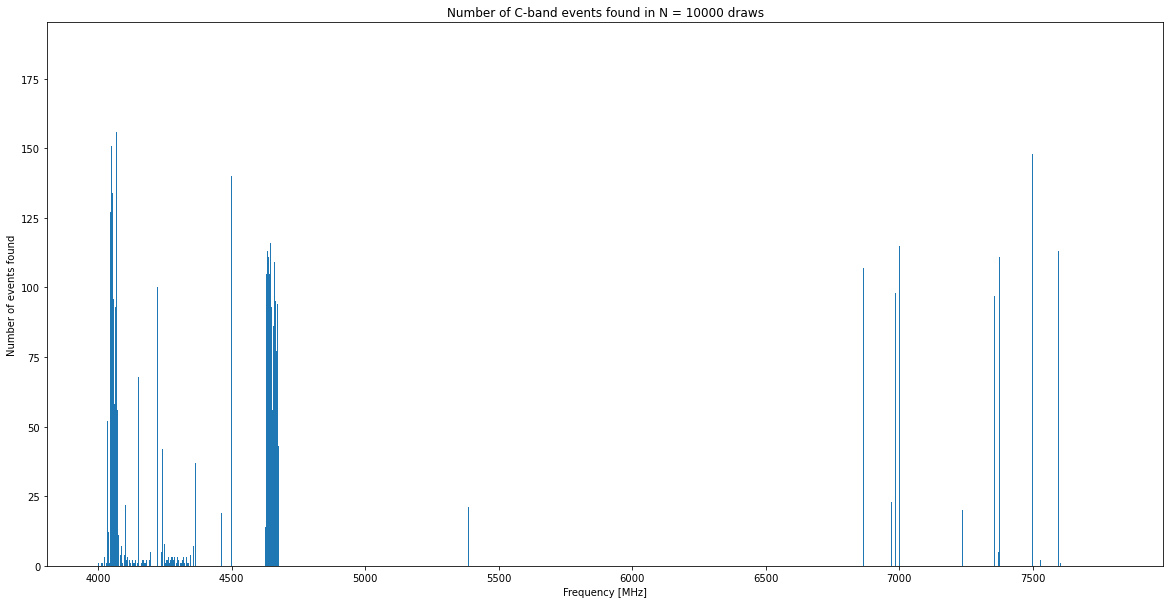

100%|██████████| 10000/10000 [00:01<00:00, 9664.31it/s]


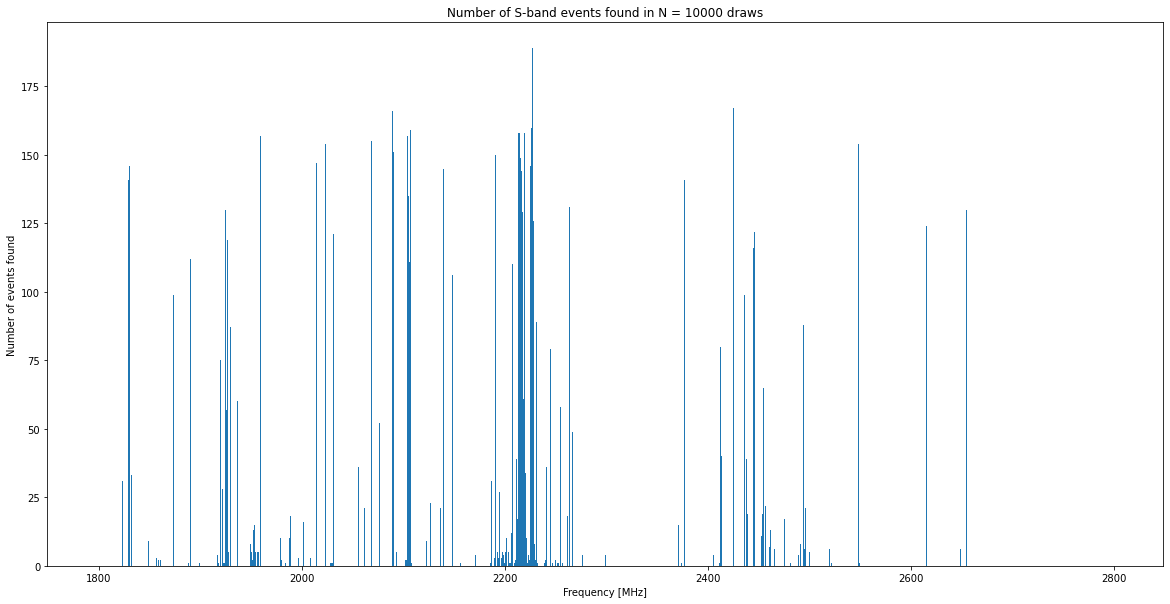

100%|██████████| 10000/10000 [00:00<00:00, 11849.61it/s]


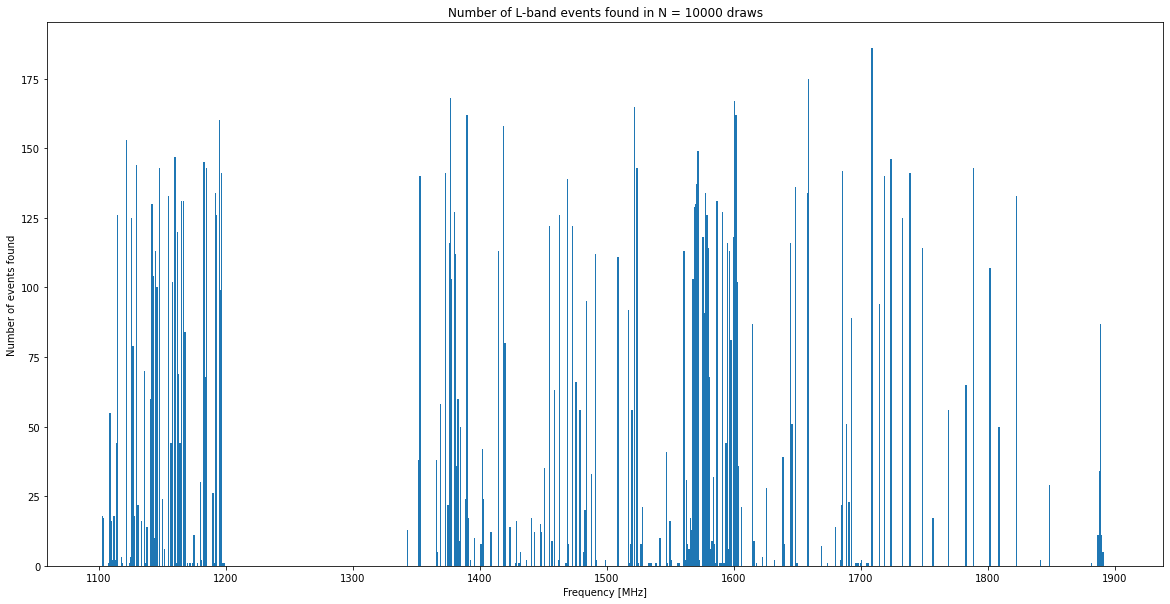

100%|██████████| 10000/10000 [00:02<00:00, 3907.51it/s]


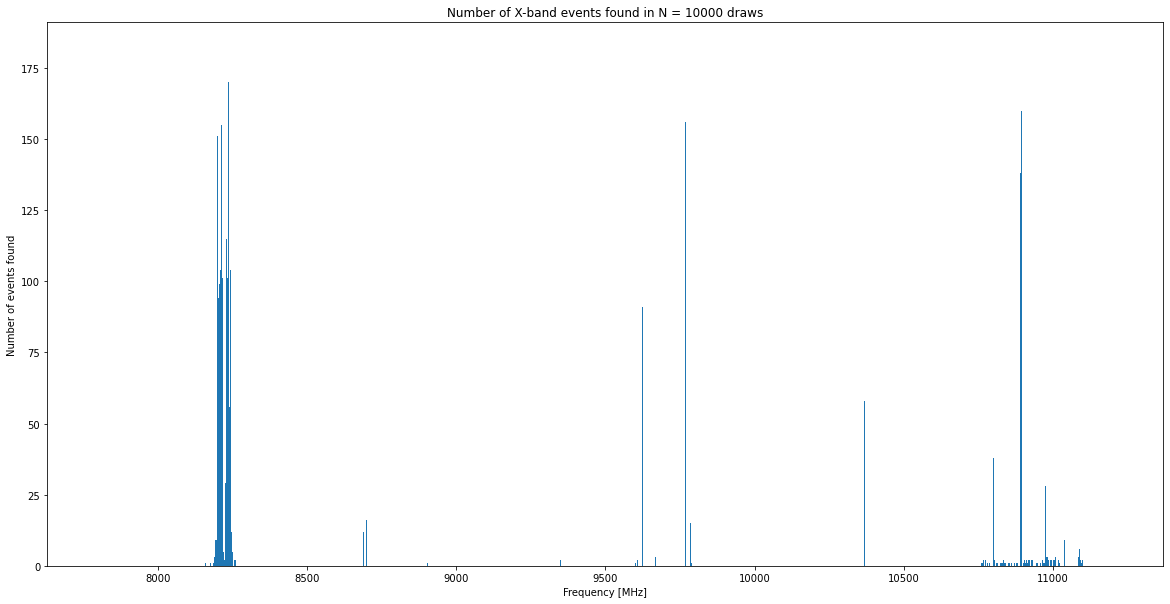

In [8]:
for i in range(4):
    data = ts_pickles[i]
    data = read_pickle(data)

    results = search_n_times(data["bin_heights"])
    event_counts = np.sum(results, axis=0)

    plt.figure(figsize=(20,10))
    plt.bar(data["bin_edges"][:-1], event_counts, width=1)
    plt.title("Number of %s-band events found in N = %i draws"%(data["band"], len(results)))
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Number of events found")
    plt.show()

# repeating the process with energy detection data

100%|██████████| 10000/10000 [00:02<00:00, 3459.62it/s]


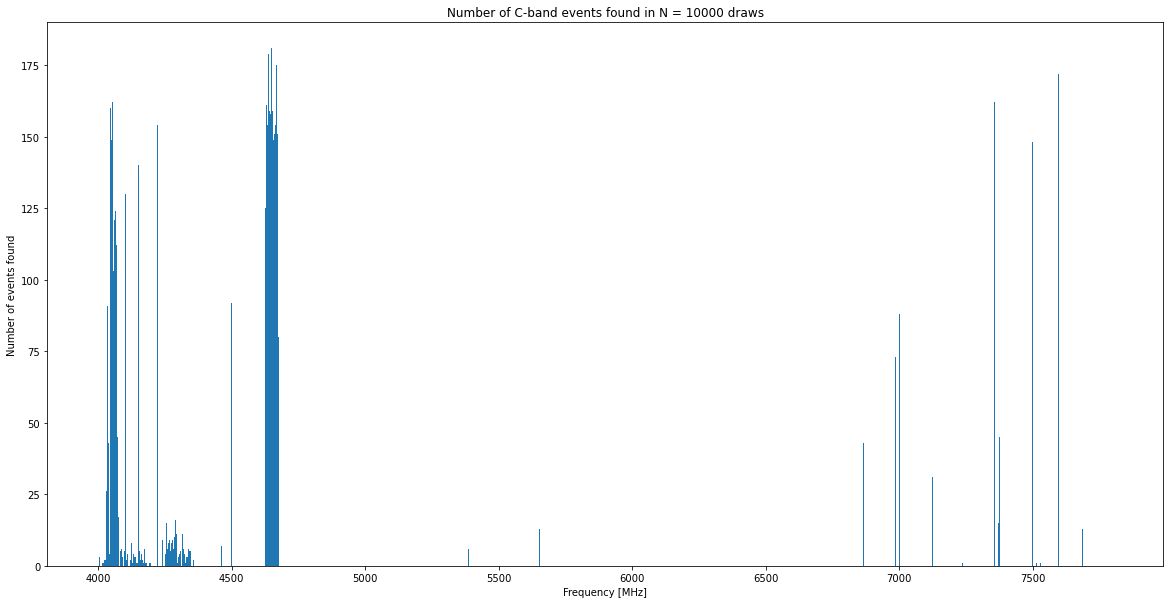

100%|██████████| 10000/10000 [00:00<00:00, 11979.34it/s]


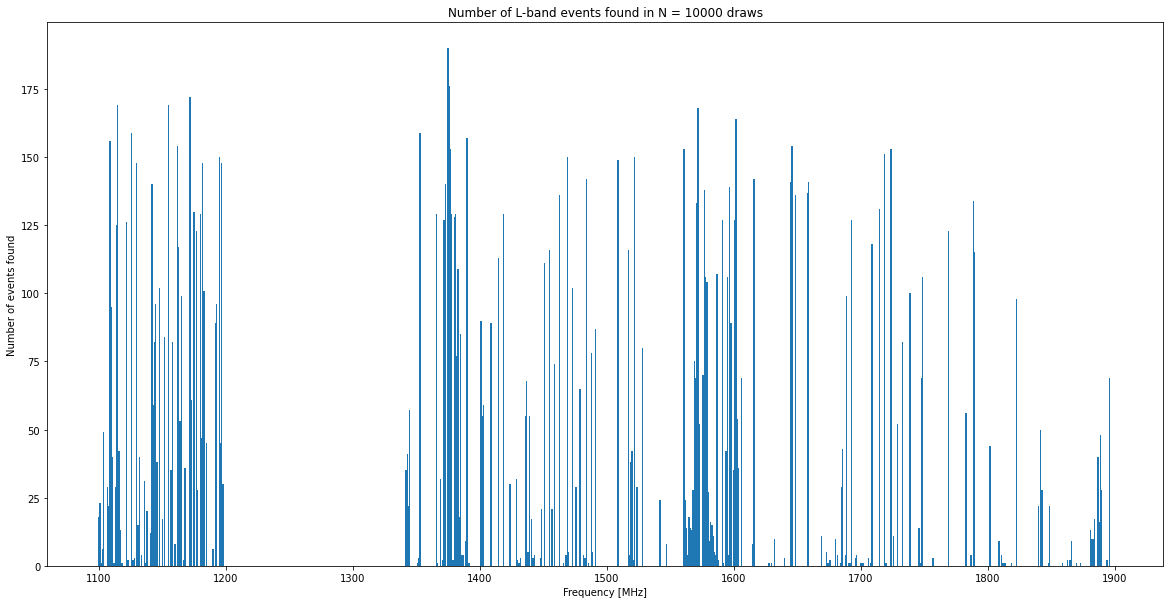

100%|██████████| 10000/10000 [00:01<00:00, 9765.06it/s]


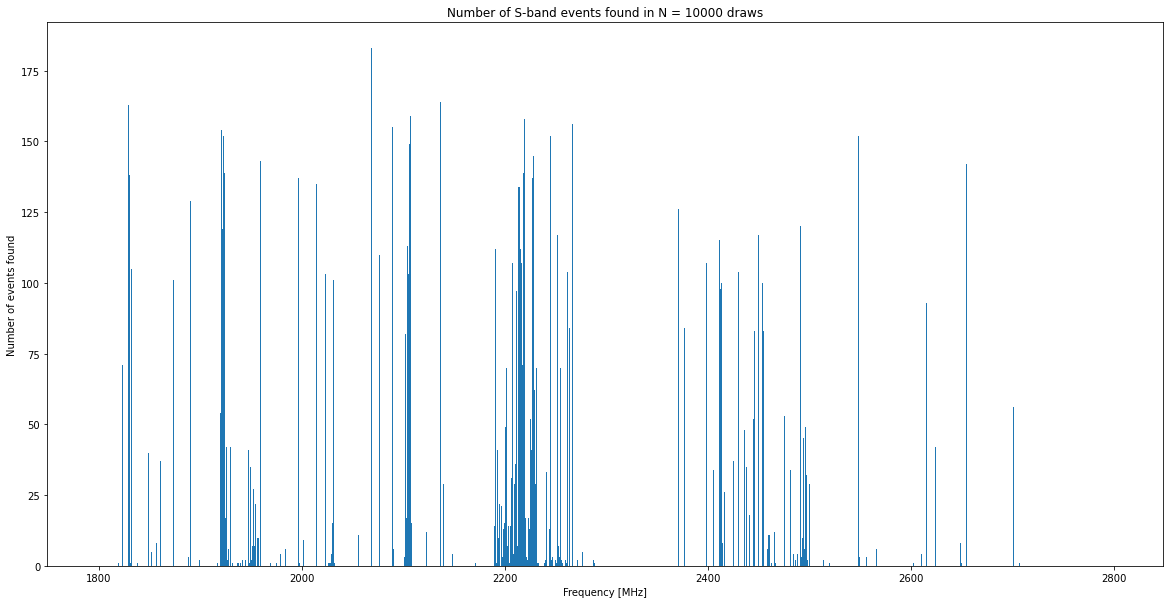

100%|██████████| 10000/10000 [00:02<00:00, 3828.40it/s]


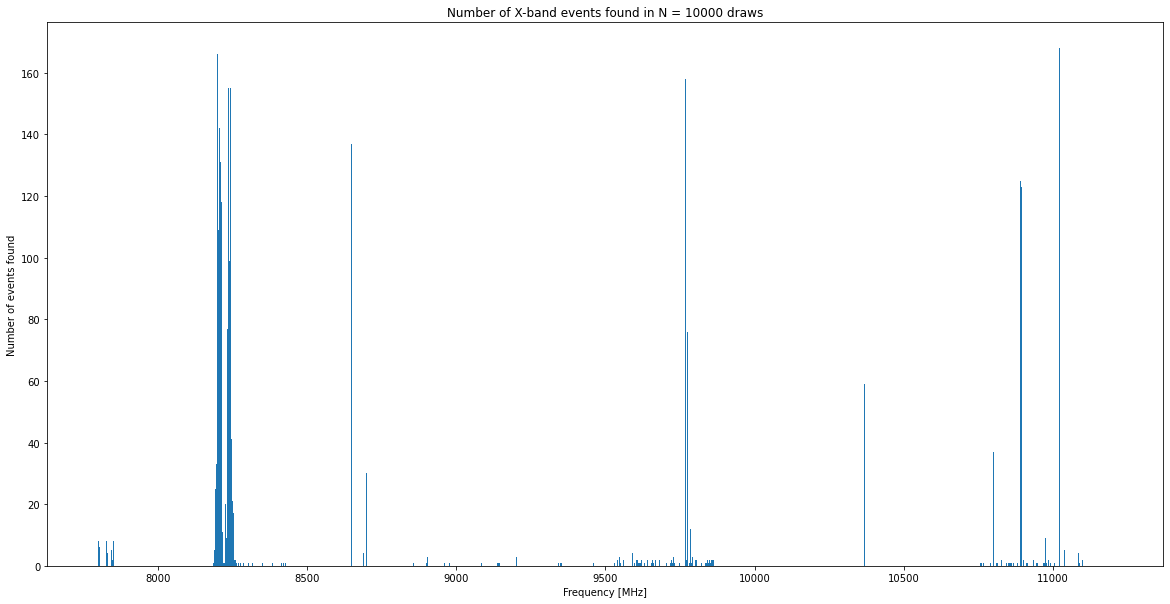

In [9]:
for i in range(4):
    data = ed_pickles[i]
    data = read_pickle(data)

    results = search_n_times(data["bin_heights"])
    event_counts = np.sum(results, axis=0)

    plt.figure(figsize=(20,10))
    plt.bar(data["bin_edges"][:-1], event_counts, width=1)
    plt.title("Number of %s-band events found in N = %i draws"%(data["band"], len(results)))
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Number of events found")
    plt.show()

# Ratio of bin height vs frequency comparing energy detection and turboSETI

In [10]:
ed_pickles

['/home/danielb/fall_2021/spectral_occupancy/energy-detection/energy_detection_C_band_spectral_occupancy_1_MHz_bins_4096.0_threshold.pkl',
 '/home/danielb/fall_2021/spectral_occupancy/energy-detection/energy_detection_L_band_spectral_occupancy_1_MHz_bins_4096.0_threshold.pkl',
 '/home/danielb/fall_2021/spectral_occupancy/energy-detection/energy_detection_S_band_spectral_occupancy_1_MHz_bins_4096.0_threshold.pkl',
 '/home/danielb/fall_2021/spectral_occupancy/energy-detection/energy_detection_X_band_spectral_occupancy_1_MHz_bins_4096.0_threshold.pkl']

In [11]:
ed_data = read_pickle(ed_pickles[1])
ts_data = read_pickle(ts_pickles[2])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


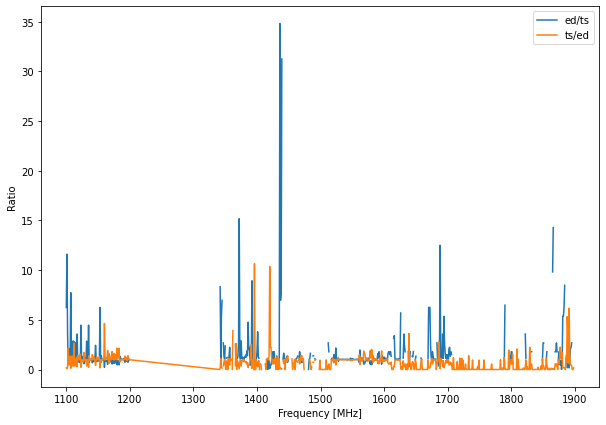

In [12]:
ed_over_ts = ed_data["bin_heights"]/ts_data["bin_heights"]
ts_over_ed = ts_data["bin_heights"]/ed_data["bin_heights"]

plt.figure(figsize=(10,7))
plt.plot(ts_data["bin_edges"][:-1], ed_over_ts, label="ed/ts")
plt.plot(ts_data["bin_edges"][:-1], ts_over_ed, label="ts/ed")
plt.legend()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Ratio")
# plt.yscale("log")
plt.show()

# Fraction of fine channels that detect a signal 

In [13]:
fine_pickles = glob.glob(fine+"*")
fine_pickles.sort()

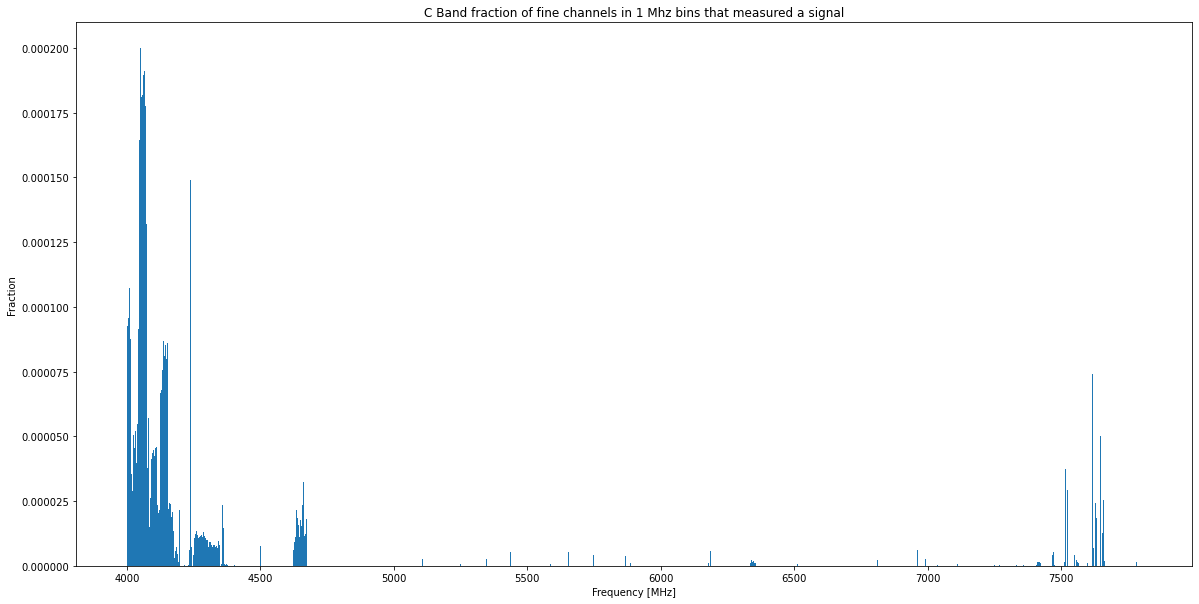

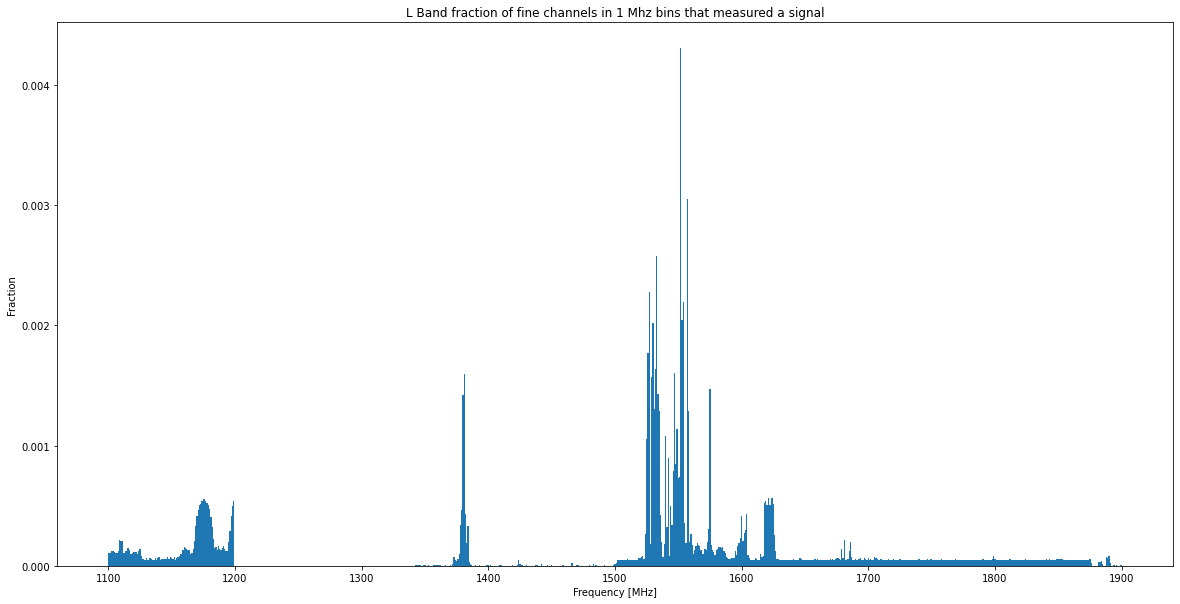

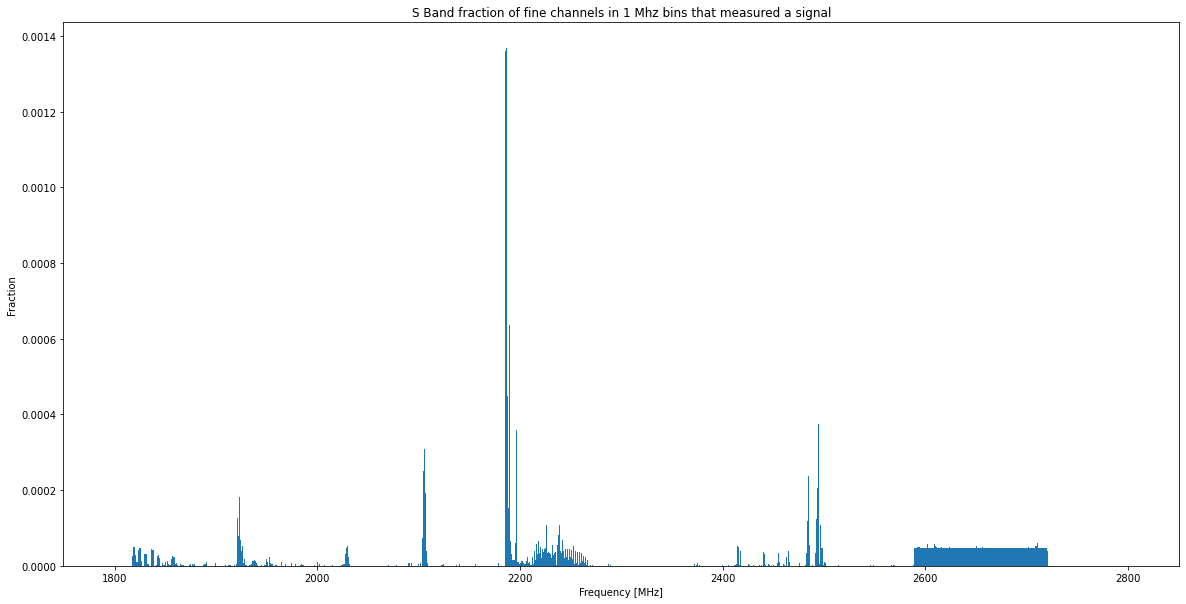

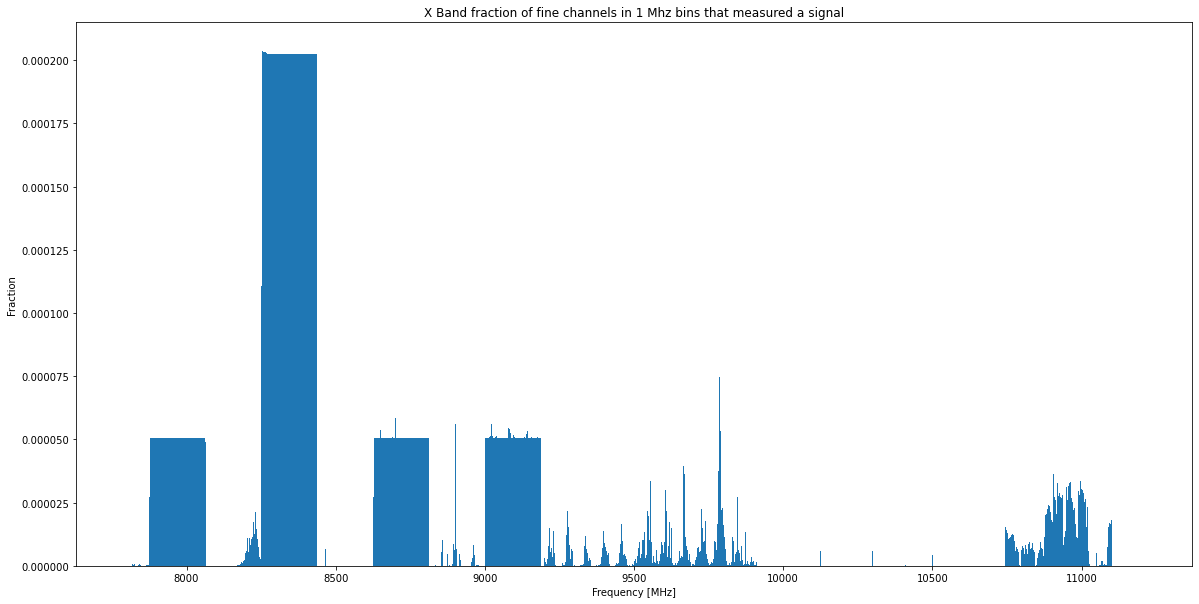

In [14]:
for i in range(4):
    fraction_data = read_pickle(fine_pickles[i])
    fractions = fraction_data["fine channel fraction"]
    frequencies = fraction_data["frequency bin"]
    
    plt.figure(figsize=(20,10))
    plt.bar(frequencies, fractions, width=1)
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Fraction")
    plt.title("%s Band fraction of fine channels in %s Mhz bins that measured a signal"%(fraction_data["band"], fraction_data["bin_width"]))

### Interesting details

X band has intervals with a much higher fraction than the surrounding

L band has an interval of constant fraction in frequencies between ~1650-1900 MHz



# Combining the fine channel fraction with the spectral occupancy

I will combine the chance of a singal being in any fine channel in the spectral occupancy bin with the chance of a bin detecting a signal by multiplying the two arrays together. In doing so, I consider these two events as independant from each other. 

I don't know how sound this method is, as a signal in  a fine channel will contribute to the spectral occupancy. Prehaps this would be better treated with Bayesian stats?

Bayes theorem:

$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

In [19]:
spec_occ = read_pickle(ed_pickles[1])["bin_heights"]
fracs = read_pickle(fine_pickles[1])["fine channel fraction"][:-1]
len(fracs), len(spec_occ)

(658, 658)

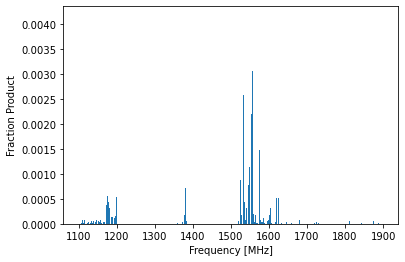

In [24]:
combined_fraction = spec_occ * fracs

plt.figure()
plt.bar(read_pickle(fine_pickles[1])["frequency bin"][:-1], combined_fraction)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Fraction Product")
plt.show()

100%|██████████| 100000/100000 [00:08<00:00, 11612.12it/s]


<BarContainer object of 658 artists>

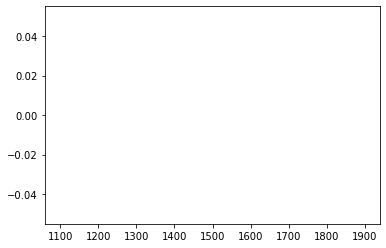

In [25]:
results = search_n_times(combined_fraction, N_iterations=100000)
event_counts = np.sum(results, axis=0)

plt.figure()
plt.bar(read_pickle(fine_pickles[1])["frequency bin"][:-1], event_counts)